In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
#import scvi
import numpy as np
import pandas as pd
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)


sys.path.insert(0, "../")
#import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, eval_scib_metrics, load_pretrained

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/h/chloexq/.local/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="fibro", # Dataset name
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="/scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model",
    model_name="best_model.pt",
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0, # DAR objective weight for batch correction
    mask_ratio=0.4, # Default mask ratio
    epochs=15, # Default number of epochs for fine-tuning
    n_bins=51, # Default number of bins for value binning in data pre-processing
    lr=1e-4, # Default learning rate for fine-tuning
    batch_size=64, # Default batch size for fine-tuning
    layer_size=128,
    nlayers=4,
    nhead=4, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
)
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chloewxq (scformer). Use `wandb login --relogin` to force relogin


{'seed': 42, 'dataset_name': 'fibro', 'do_train': True, 'load_model': '/scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model', 'model_name': 'best_model.pt', 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'mask_ratio': 0.4, 'epochs': 15, 'n_bins': 51, 'lr': 0.0001, 'batch_size': 64, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [3]:
from pathlib import Path
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 1200  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

dataset_name = config.dataset_name
save_dir = Path(f"/scratch/ssd004/scratch/chloexq/fibro/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")

save to /scratch/ssd004/scratch/chloexq/fibro/dev_fibro-Feb06-15-00


In [4]:
from pathlib import Path

## Load and preprocess dataset

####  ✅ Note
Perturbation datasets can be found in this path: `/scratch/ssd004/scratch/chloexq/perturb_analysis/{dataset_name}` 

In [5]:
data_dir = Path("/scratch/ssd004/scratch/chloexq/perturb_analysis")
adata = sc.read(data_dir / "adamson/perturb_processed.h5ad")
ori_batch_col = "control"
adata.obs["celltype"] = adata.obs["condition"].astype("category")
adata.obs["str_batch"] = adata.obs["control"].astype(str)
data_is_raw = False

In [6]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / config.model_name
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    print(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]
    
    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    print(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size 
    nhead = config.nhead
    nlayers = config.nlayers  
    d_hid = config.layer_size

match 4399/5060 genes in vocabulary of size 60697.
Resume model from /scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model/best_model.pt, the model args will be overriden by the config /scratch/ssd004/scratch/chloexq/scGPT_models/scGPT_human_model/args.json.


In [7]:
gene_names_set = [i + '+ctrl' for i in adata.var.gene_name.values]
gene_names_set = gene_names_set + ['ctrl']

####  ✅ Note
This experiment is computationally expensive, so we select 1000 cells per perturbation condition.

In [8]:
# Cap all conditions to 1000 cells
sampled_df = (
    adata.obs[adata.obs['condition'].isin(gene_names_set)]
    .groupby('condition', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 1000), random_state=42))
)
adata = adata[sampled_df.index].copy()
adata.obs.groupby('condition').count()

,cell_type,dose_val,control,condition_name,celltype,str_batch
condition,,,,,,
AMIGO3+ctrl,616,616,616,616,616,616
ARHGAP22+ctrl,406,406,406,406,406,406
ASCC3+ctrl,524,524,524,524,524,524
BHLHE40+ctrl,504,504,504,504,504,504
CAD+ctrl,242,242,242,242,242,242
...,...,...,...,...,...,...
UFM1+ctrl,591,591,591,591,591,591
XRN1+ctrl,621,621,621,621,621,621
YIPF5+ctrl,1000,1000,1000,1000,1000,1000


In [9]:
# 5 conditions are capped, including ctrl
condition_counts = adata.obs.groupby('condition').count()
condition_counts[condition_counts == 1000].dropna()

,cell_type,dose_val,control,condition_name,celltype,str_batch
condition,,,,,,
HSPA5+ctrl,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
IER3IP1+ctrl,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
SCYL1+ctrl,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
YIPF5+ctrl,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
ctrl,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0


In [10]:
condition_names = set(adata.obs.condition.tolist())

In [11]:
condition_names.remove('ctrl')

In [12]:
condition_names_gene = [i.split('+')[0] for i in list(condition_names)]

In [13]:
condition_names_gene.sort()

####  ✅ Note
HVGs selection will filter out some perturbed genes. We manually add them back in the experiment.

In [14]:
# Do filtering
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=None,  # step 2
    normalize_total=None,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=None,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    #binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    #result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...


In [15]:
sc.pp.highly_variable_genes(
    adata,
    layer=None,
    n_top_genes=1200,
    flavor="seurat_v3" if data_is_raw else "cell_ranger",
    subset=False,
)

In [16]:
add_counter = 0
for g in condition_names_gene:
    if not adata.var.loc[adata.var[adata.var.gene_name==g].index, 'highly_variable'].values[0]:
        adata.var.loc[adata.var[adata.var.gene_name==g].index, 'highly_variable'] = True
        add_counter += 1

In [17]:
print('Manually add conditions: {}, {}'.format(add_counter, add_counter/len(condition_names_gene)))

Manually add conditions: 67, 0.8933333333333333


In [18]:
# This step for binning
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=None,  # step 2
    normalize_total=None,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=None,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Binning data ...


In [19]:
adata = adata[:, adata.var["highly_variable"]].copy()
print(adata)

AnnData object with n_obs × n_vars = 39847 × 1267
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'celltype', 'str_batch'
    var: 'gene_name', 'id_in_vocab', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'hvg'
    obsm: 'bin_edges'
    layers: 'X_binned'


#### 🔵 Optional
Create another randomly shuffled list of `condition_names_gene_match` as control, if running the control experiment. 
Note that there are many ways to construct the control list, either from perturbation targets or random from all genes.

In [20]:
# Here is an example of randomly shuffle perturbation targets
import random
random.seed(42)
condition_names_gene_match = condition_names_gene.copy()
random.shuffle(condition_names_gene_match)

In [21]:
# Here is an example of using non-targets
# This is the most recent version
genes = adata.var["gene_name"].tolist()
non_targets = list(set(genes).difference(set(condition_names_gene)))
non_targets.sort()
random.seed(42)
random.shuffle(non_targets)
non_targets
condition_names_gene_match = non_targets[:len(condition_names_gene)]

In [22]:
print(condition_names_gene)

['AMIGO3', 'ARHGAP22', 'ASCC3', 'BHLHE40', 'CAD', 'CCND3', 'CHERP', 'COPB1', 'COPZ1', 'CREB1', 'DAD1', 'DDIT3', 'DDOST', 'DDRGK1', 'DERL2', 'DHDDS', 'DNAJC19', 'EIF2B2', 'EIF2B3', 'EIF2B4', 'EIF2S1', 'FARSB', 'FECH', 'GBF1', 'GMPPB', 'GNPNAT1', 'HSD17B12', 'HSPA5', 'HSPA9', 'HYOU1', 'IARS2', 'IDH3A', 'IER3IP1', 'KCTD16', 'MANF', 'MRGBP', 'MRPL39', 'MTHFD1', 'NEDD8', 'OST4', 'P4HB', 'PDIA6', 'PPWD1', 'PSMD4', 'PTDSS1', 'SAMM50', 'SCYL1', 'SEC61A1', 'SEC61B', 'SEC61G', 'SEC63', 'SEL1L', 'SLC35B1', 'SLC39A7', 'SOCS1', 'SPCS2', 'SPCS3', 'SRP68', 'SRP72', 'SRPRB', 'STT3A', 'SYVN1', 'TELO2', 'TIMM23', 'TIMM44', 'TMED10', 'TMED2', 'TMEM167A', 'TTI1', 'TTI2', 'UFL1', 'UFM1', 'XRN1', 'YIPF5', 'ZNF326']


In [23]:
print(condition_names_gene_match)

['RP5-1159O4.2', 'RP11-584P21.2', 'FBXO32', 'NUSAP1', 'PCNA', 'SKIL', 'MYOZ1', 'GADD45G', 'EEF1A1', 'MCF2L', 'DLX4', 'CCNE2', 'COCH', 'NAV2', 'KCNQ1', 'SLC39A10', 'AC023590.1', 'CAPN2', 'PTPN7', 'TUBB1', 'SLC6A20', 'RP11-96K19.2', 'STAR', 'OR8D1', 'TRIM24', 'KDM7A', 'HSPA8', 'SLC7A8', 'PSRC1', 'TGIF1', 'NR4A1', 'PTH2', 'DLGAP5', 'NMU', 'RBPMS', 'LGALS3', 'PSAT1', 'AQP1', 'RP11-867G2.8', 'MYLIP', 'F8', 'PTTG1', 'HNMT', 'FNDC4', 'RP11-320G24.1', 'BAIAP3', 'CTC-203F4.2', 'HOTAIRM1', 'SMC4', 'MRAP2', 'FEV', 'RP11-1277A3.1', 'HMGCS1', 'RP11-422P24.10', 'RIMS3', 'IFITM1', 'VIM', 'PPP3CA', 'HBZ', 'IL4R', 'TNFAIP2', 'SQSTM1', 'PCK2', 'LGALS1', 'MUC4', 'AQP3', 'AP000640.10', 'AC034243.1', 'KALRN', 'SEC24D', 'RP11-727F15.9', 'ABTB2', 'LIMS1', 'PRSS57', 'ARL6IP1']


## Prepare model input

In [24]:
max_len = adata.shape[1] + 1
max_len

1268

In [25]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)
adata.obs['batch_id'] = adata.obs['condition'].copy()
batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
input_layer_key = "X_binned"

In [26]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

## Load the pre-trained scGPT model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=False,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=False,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    load_pretrained(model, torch.load(model_file), verbose=False)

model.to(device)
wandb.watch(model)

Using simple batchnorm instead of domain specific batchnorm


[]

In [28]:
model.eval()
adata_t = adata.copy()

In [29]:
all_counts = (
    adata_t.layers[input_layer_key].A
    if issparse(adata_t.layers[input_layer_key])
    else adata_t.layers[input_layer_key]
)
celltypes_labels = adata_t.obs["celltype"].tolist()
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata_t.obs["batch_id"].tolist()
batch_ids = np.array(batch_ids)

tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=max_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

##  Get gene embeddings

In [30]:
with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
    gene_embeddings = model.encode_batch(
        all_gene_ids,
        all_values.float(),
        src_key_padding_mask=src_key_padding_mask,
        batch_size=config.batch_size,
        batch_labels=None,
        return_np=True,
    )

100%|██████████| 623/623 [04:45<00:00,  2.18it/s]


In [31]:
gene_embeddings.shape

(39847, 1268, 512)

In [32]:
all_gene_ids

tensor([[60695, 10954, 33817,  ..., 11394, 20695, 12288],
        [60695, 10954, 33817,  ..., 11394, 20695, 12288],
        [60695, 10954, 33817,  ..., 11394, 20695, 12288],
        ...,
        [60695, 10954, 33817,  ..., 11394, 20695, 12288],
        [60695, 10954, 33817,  ..., 11394, 20695, 12288],
        [60695, 10954, 33817,  ..., 11394, 20695, 12288]])

In [33]:
len(genes)

1267

In [34]:
gene_embeddings.shape

(39847, 1268, 512)

In [35]:
condition_ids = np.array(adata_t.obs["condition"].tolist())

#### ✅ Note
Each perturbation group has one n_gene x 512 aggreagted profile associated with it

In [36]:
dict_sum_condition = {}
for i, c in enumerate(condition_ids):
    if c in dict_sum_condition:
        dict_sum_condition[c]+=gene_embeddings[i, :, :]
    else:
        dict_sum_condition[c]=gene_embeddings[i, :, :]

In [37]:
dict_sum_condition_mean = {}
groups = adata_t.obs.groupby('condition').groups
for i in groups.keys():
    dict_sum_condition_mean[i] = dict_sum_condition[i]/len(groups[i])

In [38]:
dict_sum_condition_mean['AMIGO3+ctrl'].shape

(1268, 512)

In [39]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [40]:
perturb_conditions = list(dict_sum_condition_mean.keys())
len(perturb_conditions)

76

In [41]:
perturb_conditions.remove('ctrl')

In [42]:
assert 'ctrl' not in perturb_conditions

In [43]:
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm
import pandas as pd

#### ✅ Note
Calculate consine distance between control and each perturbation conditions

In [44]:
rank_list = []

In [45]:
for c in perturb_conditions:
    celltype_0 = c
    celltype_1 = 'ctrl'
    gene_emb_celltype_0 = np.expand_dims(dict_sum_condition_mean[celltype_0][1:, :], 0)
    gene_emb_celltype_1 = np.expand_dims(dict_sum_condition_mean[celltype_1][1:, :], 0)
    gene_dist_dict = {}
    for i, g in tqdm(enumerate(genes)):
        gene_dist_dict[g] = cosine_distances(gene_emb_celltype_0[:, i, :], gene_emb_celltype_1[:, i, :]).mean()
    df_gene_emb_dist = pd.DataFrame.from_dict(gene_dist_dict, orient='index', columns=['cos_dist'])
    df_deg = df_gene_emb_dist.sort_values(by='cos_dist', ascending=False)
    print(c, np.where(df_deg.index==c.split('+')[0])[0][0])
    rank_list.append(np.where(df_deg.index==c.split('+')[0])[0][0])

1267it [00:00, 3164.02it/s]


AMIGO3+ctrl 409


1267it [00:00, 3366.80it/s]


ARHGAP22+ctrl 126


1267it [00:00, 3105.31it/s]


ASCC3+ctrl 48


1267it [00:00, 3147.08it/s]


BHLHE40+ctrl 558


1267it [00:00, 3592.24it/s]


CAD+ctrl 557


1267it [00:00, 3517.92it/s]


CCND3+ctrl 3


1267it [00:00, 3578.69it/s]


CHERP+ctrl 34


1267it [00:00, 3337.85it/s]


COPB1+ctrl 933


1267it [00:00, 3514.65it/s]


COPZ1+ctrl 5


1267it [00:00, 3545.82it/s]


CREB1+ctrl 110


1267it [00:00, 3446.62it/s]


DAD1+ctrl 0


1267it [00:00, 3560.05it/s]


DDIT3+ctrl 298


1267it [00:00, 3467.19it/s]


DDOST+ctrl 2


1267it [00:00, 3325.94it/s]


DDRGK1+ctrl 2


1267it [00:00, 3224.86it/s]


DERL2+ctrl 10


1267it [00:00, 3307.58it/s]


DHDDS+ctrl 212


1267it [00:00, 3326.76it/s]


DNAJC19+ctrl 5


1267it [00:00, 2978.32it/s]


EIF2B2+ctrl 529


1267it [00:00, 3127.08it/s]


EIF2B3+ctrl 51


1267it [00:00, 3267.39it/s]


EIF2B4+ctrl 208


1267it [00:00, 3203.81it/s]


EIF2S1+ctrl 38


1267it [00:00, 3180.06it/s]


FARSB+ctrl 5


1267it [00:00, 3142.43it/s]


FECH+ctrl 228


1267it [00:00, 3278.99it/s]


GBF1+ctrl 40


1267it [00:00, 3164.75it/s]


GMPPB+ctrl 1010


1267it [00:00, 3140.60it/s]


GNPNAT1+ctrl 10


1267it [00:00, 3010.59it/s]


HSD17B12+ctrl 6


1267it [00:00, 3098.79it/s]


HSPA5+ctrl 2


1267it [00:00, 3181.82it/s]


HSPA9+ctrl 5


1267it [00:00, 3073.06it/s]


HYOU1+ctrl 48


1267it [00:00, 3167.57it/s]


IARS2+ctrl 327


1267it [00:00, 3119.90it/s]


IDH3A+ctrl 11


1267it [00:00, 2957.32it/s]


IER3IP1+ctrl 15


1267it [00:00, 3172.56it/s]


KCTD16+ctrl 112


1267it [00:00, 3112.66it/s]


MANF+ctrl 1


1267it [00:00, 3374.57it/s]


MRGBP+ctrl 11


1267it [00:00, 3296.08it/s]


MRPL39+ctrl 14


1267it [00:00, 3548.18it/s]


MTHFD1+ctrl 23


1267it [00:00, 3526.30it/s]


NEDD8+ctrl 0


1267it [00:00, 3557.32it/s]


OST4+ctrl 0


1267it [00:00, 3564.38it/s]


P4HB+ctrl 0


1267it [00:00, 3501.01it/s]


PDIA6+ctrl 0


1267it [00:00, 3437.95it/s]


PPWD1+ctrl 117


1267it [00:00, 3468.43it/s]


PSMD4+ctrl 15


1267it [00:00, 3465.43it/s]


PTDSS1+ctrl 12


1267it [00:00, 3523.72it/s]


SAMM50+ctrl 21


1267it [00:00, 3071.42it/s]


SCYL1+ctrl 20


1267it [00:00, 3081.88it/s]


SEC61A1+ctrl 29


1267it [00:00, 3140.58it/s]


SEC61B+ctrl 0


1267it [00:00, 3154.34it/s]


SEC61G+ctrl 0


1267it [00:00, 3055.08it/s]


SEC63+ctrl 3


1267it [00:00, 3252.82it/s]


SEL1L+ctrl 123


1267it [00:00, 3189.98it/s]


SLC35B1+ctrl 3


1267it [00:00, 3238.86it/s]


SLC39A7+ctrl 21


1267it [00:00, 3059.30it/s]


SOCS1+ctrl 524


1267it [00:00, 3134.94it/s]


SPCS2+ctrl 0


1267it [00:00, 2949.38it/s]


SPCS3+ctrl 12


1267it [00:00, 2993.49it/s]


SRP68+ctrl 33


1267it [00:00, 3240.84it/s]


SRP72+ctrl 0


1267it [00:00, 3079.29it/s]


SRPRB+ctrl 20


1267it [00:00, 3059.49it/s]


STT3A+ctrl 126


1267it [00:00, 3214.77it/s]


SYVN1+ctrl 16


1267it [00:00, 3211.28it/s]


TELO2+ctrl 23


1267it [00:00, 3262.33it/s]


TIMM23+ctrl 54


1267it [00:00, 3237.70it/s]


TIMM44+ctrl 231


1267it [00:00, 3284.95it/s]


TMED2+ctrl 0


1267it [00:00, 3264.16it/s]


TMED10+ctrl 5


1267it [00:00, 3235.17it/s]


TMEM167A+ctrl 5


1267it [00:00, 2877.34it/s]


TTI1+ctrl 42


1267it [00:00, 3606.40it/s]


TTI2+ctrl 77


1267it [00:00, 3339.84it/s]


UFL1+ctrl 39


1267it [00:00, 3484.94it/s]


UFM1+ctrl 2


1267it [00:00, 3393.67it/s]


XRN1+ctrl 206


1267it [00:00, 2879.57it/s]


YIPF5+ctrl 55


1267it [00:00, 3535.77it/s]

ZNF326+ctrl 434


In [46]:
df_results = pd.read_csv('./vevo_adamson_ranks_Jan17.csv', index_col=0)
df_results

,conditions,wilcoxon,scGPT_rank (attn),scGPT_rank (gene emb),"scGPT_rank (attn, mean)","scGPT_rank (gene emb, mean)",wilcoxon (random),"scGPT_rank (attn, random)","scGPT_rank (gene emb, random)","scGPT_rank (attn, random, null)","scGPT_rank (gene emb, random, null)","scGPT_rank (attn, null, targets)","scGPT_rank (attn, null, non-targets)","scGPT_rank (gene emb, null, targets)","scGPT_rank (gene emb, null, non-targets)",scGPT_rank (masked gene emb),"scGPT_rank (masked gene emb, null)"
0,AMIGO3+ctrl,1098,569,409,569,409,1098,569,409,1,1,586,497,1125,234,413,306
1,ARHGAP22+ctrl,318,175,126,0,0,837,0,0,5,3,565,69,1130,93,571,333
2,ASCC3+ctrl,36,15,48,0,0,834,5,7,14,2,248,651,1194,608,546,1215
3,BHLHE40+ctrl,3,584,558,0,0,1075,25,1,91,211,56,867,836,1114,663,708
4,CAD+ctrl,93,257,557,0,0,1257,59,28,58,58,819,1194,1222,1247,1097,780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,UFL1+ctrl,19,3,39,0,0,962,6,5,369,53,1012,287,1188,809,417,634
71,UFM1+ctrl,0,4,2,0,0,612,21,1,4,1,743,405,786,283,111,522
72,XRN1+ctrl,216,163,206,0,0,789,71,127,6,2,832,59,858,9,1028,431
73,YIPF5+ctrl,11,16,55,0,0,1061,12,3,0,0,319,477,733,240,1223,246


In [47]:
df_results['scGPT_rank (gene emb) demo'] = rank_list

In [48]:
df_results

,conditions,wilcoxon,scGPT_rank (attn),scGPT_rank (gene emb),"scGPT_rank (attn, mean)","scGPT_rank (gene emb, mean)",wilcoxon (random),"scGPT_rank (attn, random)","scGPT_rank (gene emb, random)","scGPT_rank (attn, random, null)","scGPT_rank (gene emb, random, null)","scGPT_rank (attn, null, targets)","scGPT_rank (attn, null, non-targets)","scGPT_rank (gene emb, null, targets)","scGPT_rank (gene emb, null, non-targets)",scGPT_rank (masked gene emb),"scGPT_rank (masked gene emb, null)",scGPT_rank (gene emb) demo
0,AMIGO3+ctrl,1098,569,409,569,409,1098,569,409,1,1,586,497,1125,234,413,306,409
1,ARHGAP22+ctrl,318,175,126,0,0,837,0,0,5,3,565,69,1130,93,571,333,126
2,ASCC3+ctrl,36,15,48,0,0,834,5,7,14,2,248,651,1194,608,546,1215,48
3,BHLHE40+ctrl,3,584,558,0,0,1075,25,1,91,211,56,867,836,1114,663,708,558
4,CAD+ctrl,93,257,557,0,0,1257,59,28,58,58,819,1194,1222,1247,1097,780,557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,UFL1+ctrl,19,3,39,0,0,962,6,5,369,53,1012,287,1188,809,417,634,39
71,UFM1+ctrl,0,4,2,0,0,612,21,1,4,1,743,405,786,283,111,522,2
72,XRN1+ctrl,216,163,206,0,0,789,71,127,6,2,832,59,858,9,1028,431,206
73,YIPF5+ctrl,11,16,55,0,0,1061,12,3,0,0,319,477,733,240,1223,246,55


In [49]:
df_results.mean()

wilcoxon                                     69.920000
scGPT_rank (attn)                            83.160000
scGPT_rank (gene emb)                       110.320000
scGPT_rank (attn, mean)                      70.506667
scGPT_rank (gene emb, mean)                  68.320000
wilcoxon (random)                           848.866667
scGPT_rank (attn, random)                   122.093333
scGPT_rank (gene emb, random)                83.560000
scGPT_rank (attn, random, null)             151.720000
scGPT_rank (gene emb, random, null)         102.866667
scGPT_rank (attn, null, targets)            594.253333
scGPT_rank (attn, null, non-targets)        649.573333
scGPT_rank (gene emb, null, targets)        712.880000
scGPT_rank (gene emb, null, non-targets)    559.960000
scGPT_rank (masked gene emb)                747.000000
scGPT_rank (masked gene emb, null)          640.973333
scGPT_rank (gene emb) demo                  110.320000
dtype: float64

In [64]:
#df_results.to_csv('/fs01/home/chloexq/scGPT-release/tutorials/vevo_adamson_ranks_Nov28.csv')

#### 🔵 Optional
For control experiment, run the following block using `condition_names_gene_match`
Logic is that in each perturbed cell, check the rank of another gene

In [ ]:
rank_list = []
for i, c in enumerate(perturb_conditions):
    celltype_0 = c
    celltype_1 = 'ctrl'
    gene_emb_celltype_0 = np.expand_dims(dict_sum_condition_mean[celltype_0][1:, 1:], 0)
    gene_emb_celltype_1 = np.expand_dims(dict_sum_condition_mean[celltype_1][1:, 1:], 0)
    gene_dist_dict = {}
    for i, g in tqdm(enumerate(genes)):
        gene_dist_dict[g] = cosine_distances(gene_emb_celltype_0[:, i, :], gene_emb_celltype_1[:, i, :]).mean()
    df_gene_emb_dist = pd.DataFrame.from_dict(gene_dist_dict, orient='index', columns=['cos_dist'])
    df_deg = df_gene_emb_dist.sort_values(by='cos_dist', ascending=False)
    c = condition_names_gene_match.pop(0)
    print(c, np.where(df_deg.index==c.split('+')[0])[0][0])
    rank_list.append(np.where(df_deg.index==c.split('+')[0])[0][0])

## Baseline Wilcoxon

In [50]:
df_results = pd.DataFrame()

In [51]:
df_results['conditions'] = perturb_conditions
df_results['scGPT_rank'] = rank_list

In [52]:
df_results

,conditions,scGPT_rank
0,AMIGO3+ctrl,409
1,ARHGAP22+ctrl,126
2,ASCC3+ctrl,48
3,BHLHE40+ctrl,558
4,CAD+ctrl,557
...,...,...
70,UFL1+ctrl,39
71,UFM1+ctrl,2
72,XRN1+ctrl,206
73,YIPF5+ctrl,55


In [53]:
adata_t_sub_copy = adata_t.copy()
adata_t_sub_copy.X = adata_t_sub_copy.X
adata_t_sub_copy.var.index = genes

In [54]:
adata_t_sub_copy

AnnData object with n_obs × n_vars = 39847 × 1267
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'celltype', 'str_batch', 'batch_id'
    var: 'gene_name', 'id_in_vocab', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'hvg'
    obsm: 'bin_edges'
    layers: 'X_binned'

In [55]:
sc.tl.rank_genes_groups(adata_t_sub_copy, 'condition', method='wilcoxon', key_added = "wilcoxon", n_genes=max_len-1, reference
='ctrl')

In [56]:
adata_t_sub_copy

AnnData object with n_obs × n_vars = 39847 × 1267
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'celltype', 'str_batch', 'batch_id'
    var: 'gene_name', 'id_in_vocab', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'hvg', 'wilcoxon'
    obsm: 'bin_edges'
    layers: 'X_binned'

In [57]:
adata_t_sub_copy.uns['wilcoxon']['names']

rec.array([('CITED2', 'SH3BGRL3', 'SH3BGRL3', 'EEF1A1', 'BLVRB', 'ALAS2', 'GYPB', 'SH3BGRL3', 'SH3BGRL3', 'EEF1A1', 'PDIA3', 'EEF1A1', 'PDIA6', 'CITED2', 'SH3BGRL3', 'PDIA6', 'SH3BGRL3', 'PRSS57', 'PHGDH', 'PRSS57', 'S100A11', 'PHGDH', 'CITED2', 'CITED2', 'CITED2', 'CITED2', 'SH3BGRL3', 'PDIA6', 'S100A11', 'CITED2', 'PHGDH', 'KLF1', 'PDIA6', 'CITED2', 'CITED2', 'HES4', 'CITED2', 'BLVRB', 'SH3BGRL3', 'CITED2', 'CITED2', 'CITED2', 'CLCA1', 'BLVRB', 'CITED2', 'SERPINF1', 'CALR', 'SLC3A2', 'SLC3A2', 'SLC3A2', 'CITED2', 'HSPA5', 'CITED2', 'PDIA6', 'PDIA6', 'CITED2', 'PDIA6', 'SLC3A2', 'CITED2', 'SLC3A2', 'CITED2', 'PDIA3', 'SH3BGRL3', 'SH3BGRL3', 'PHGDH', 'SH3BGRL3', 'CITED2', 'PDIA6', 'RHCE', 'CITED2', 'PDIA6', 'CITED2', 'CLCA1', 'PDIA6', 'EEF1A1'),
           ('PDIA3', 'LIMS1', 'CITED2', 'AIF1', 'ALAS2', 'GYPB', 'CITED2', 'NFKBIA', 'NFKBIA', 'RPSAP58', 'PDIA6', 'RPSAP58', 'PDIA3', 'PDIA6', 'PDIA3', 'HSP90B1', 'PRSS57', 'PHGDH', 'S100A11', 'PHGDH', 'UBE2L6', 'SERPINF1', 'SH3BGRL3', 'FCER1G

In [58]:
baseline_rank = []

In [59]:
for c in perturb_conditions:
    hvg_list = adata_t_sub_copy.uns['wilcoxon']['names'][c]
    p_val = adata_t_sub_copy.uns['wilcoxon']['pvals_adj'][c]
    df_gene_emb_dist = pd.DataFrame()
    df_gene_emb_dist['gene'] = hvg_list
    df_gene_emb_dist['p_val'] = p_val
    df_gene_emb_dist = df_gene_emb_dist.sort_values(by='p_val')
    print(c, np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])
    baseline_rank.append(np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])

AMIGO3+ctrl 1098
ARHGAP22+ctrl 318
ASCC3+ctrl 36
BHLHE40+ctrl 3
CAD+ctrl 93
CCND3+ctrl 0
CHERP+ctrl 35
COPB1+ctrl 112
COPZ1+ctrl 0
CREB1+ctrl 73
DAD1+ctrl 0
DDIT3+ctrl 0
DDOST+ctrl 0
DDRGK1+ctrl 0
DERL2+ctrl 0
DHDDS+ctrl 119
DNAJC19+ctrl 0
EIF2B2+ctrl 26
EIF2B3+ctrl 2
EIF2B4+ctrl 14
EIF2S1+ctrl 4
FARSB+ctrl 0
FECH+ctrl 55
GBF1+ctrl 141
GMPPB+ctrl 1211
GNPNAT1+ctrl 3
HSD17B12+ctrl 3
HSPA5+ctrl 29
HSPA9+ctrl 2
HYOU1+ctrl 2
IARS2+ctrl 22
IDH3A+ctrl 1
IER3IP1+ctrl 2
KCTD16+ctrl 1028
MANF+ctrl 0
MRGBP+ctrl 3
MRPL39+ctrl 0
MTHFD1+ctrl 7
NEDD8+ctrl 0
OST4+ctrl 0
P4HB+ctrl 0
PDIA6+ctrl 0
PPWD1+ctrl 52
PSMD4+ctrl 0
PTDSS1+ctrl 0
SAMM50+ctrl 0
SCYL1+ctrl 9
SEC61A1+ctrl 4
SEC61B+ctrl 0
SEC61G+ctrl 0
SEC63+ctrl 0
SEL1L+ctrl 105
SLC35B1+ctrl 0
SLC39A7+ctrl 0
SOCS1+ctrl 86
SPCS2+ctrl 0
SPCS3+ctrl 0
SRP68+ctrl 3
SRP72+ctrl 0
SRPRB+ctrl 0
STT3A+ctrl 75
SYVN1+ctrl 20
TELO2+ctrl 26
TIMM23+ctrl 2
TIMM44+ctrl 2
TMED2+ctrl 0
TMED10+ctrl 0
TMEM167A+ctrl 0
TTI1+ctrl 63
TTI2+ctrl 109
UFL1+ctrl 19
UFM1+ctrl 0


In [60]:
df_results

,conditions,scGPT_rank
0,AMIGO3+ctrl,409
1,ARHGAP22+ctrl,126
2,ASCC3+ctrl,48
3,BHLHE40+ctrl,558
4,CAD+ctrl,557
...,...,...
70,UFL1+ctrl,39
71,UFM1+ctrl,2
72,XRN1+ctrl,206
73,YIPF5+ctrl,55


In [61]:
df_results['wilcoxon (random)'] = baseline_rank

In [62]:
df_results

,conditions,scGPT_rank,wilcoxon (random)
0,AMIGO3+ctrl,409,1098
1,ARHGAP22+ctrl,126,318
2,ASCC3+ctrl,48,36
3,BHLHE40+ctrl,558,3
4,CAD+ctrl,557,93
...,...,...,...
70,UFL1+ctrl,39,19
71,UFM1+ctrl,2,0
72,XRN1+ctrl,206,216
73,YIPF5+ctrl,55,11


In [63]:
df_results.mean()

scGPT_rank           110.32
wilcoxon (random)     69.92
dtype: float64

## Misc / Plotting

In [62]:
df_results_old = pd.read_csv('/fs01/home/chloexq/scGPT-release/tutorials/vevo_adamson_ranks_Nov21.csv', index_col=0)

In [72]:
df_results_old

,conditions,wilcoxon,scGPT_rank (attn),scGPT_rank (gene emb)
0,AMIGO3+ctrl,1098,569,409
1,ARHGAP22+ctrl,318,175,126
2,ASCC3+ctrl,36,15,48
3,BHLHE40+ctrl,3,584,558
4,CAD+ctrl,93,257,557
...,...,...,...,...
70,UFL1+ctrl,19,3,39
71,UFM1+ctrl,0,4,2
72,XRN1+ctrl,216,163,206
73,YIPF5+ctrl,11,16,55


In [74]:
df_results_old.columns

Index(['conditions', 'wilcoxon', 'scGPT_rank (attn)', 'scGPT_rank (gene emb)'], dtype='object')

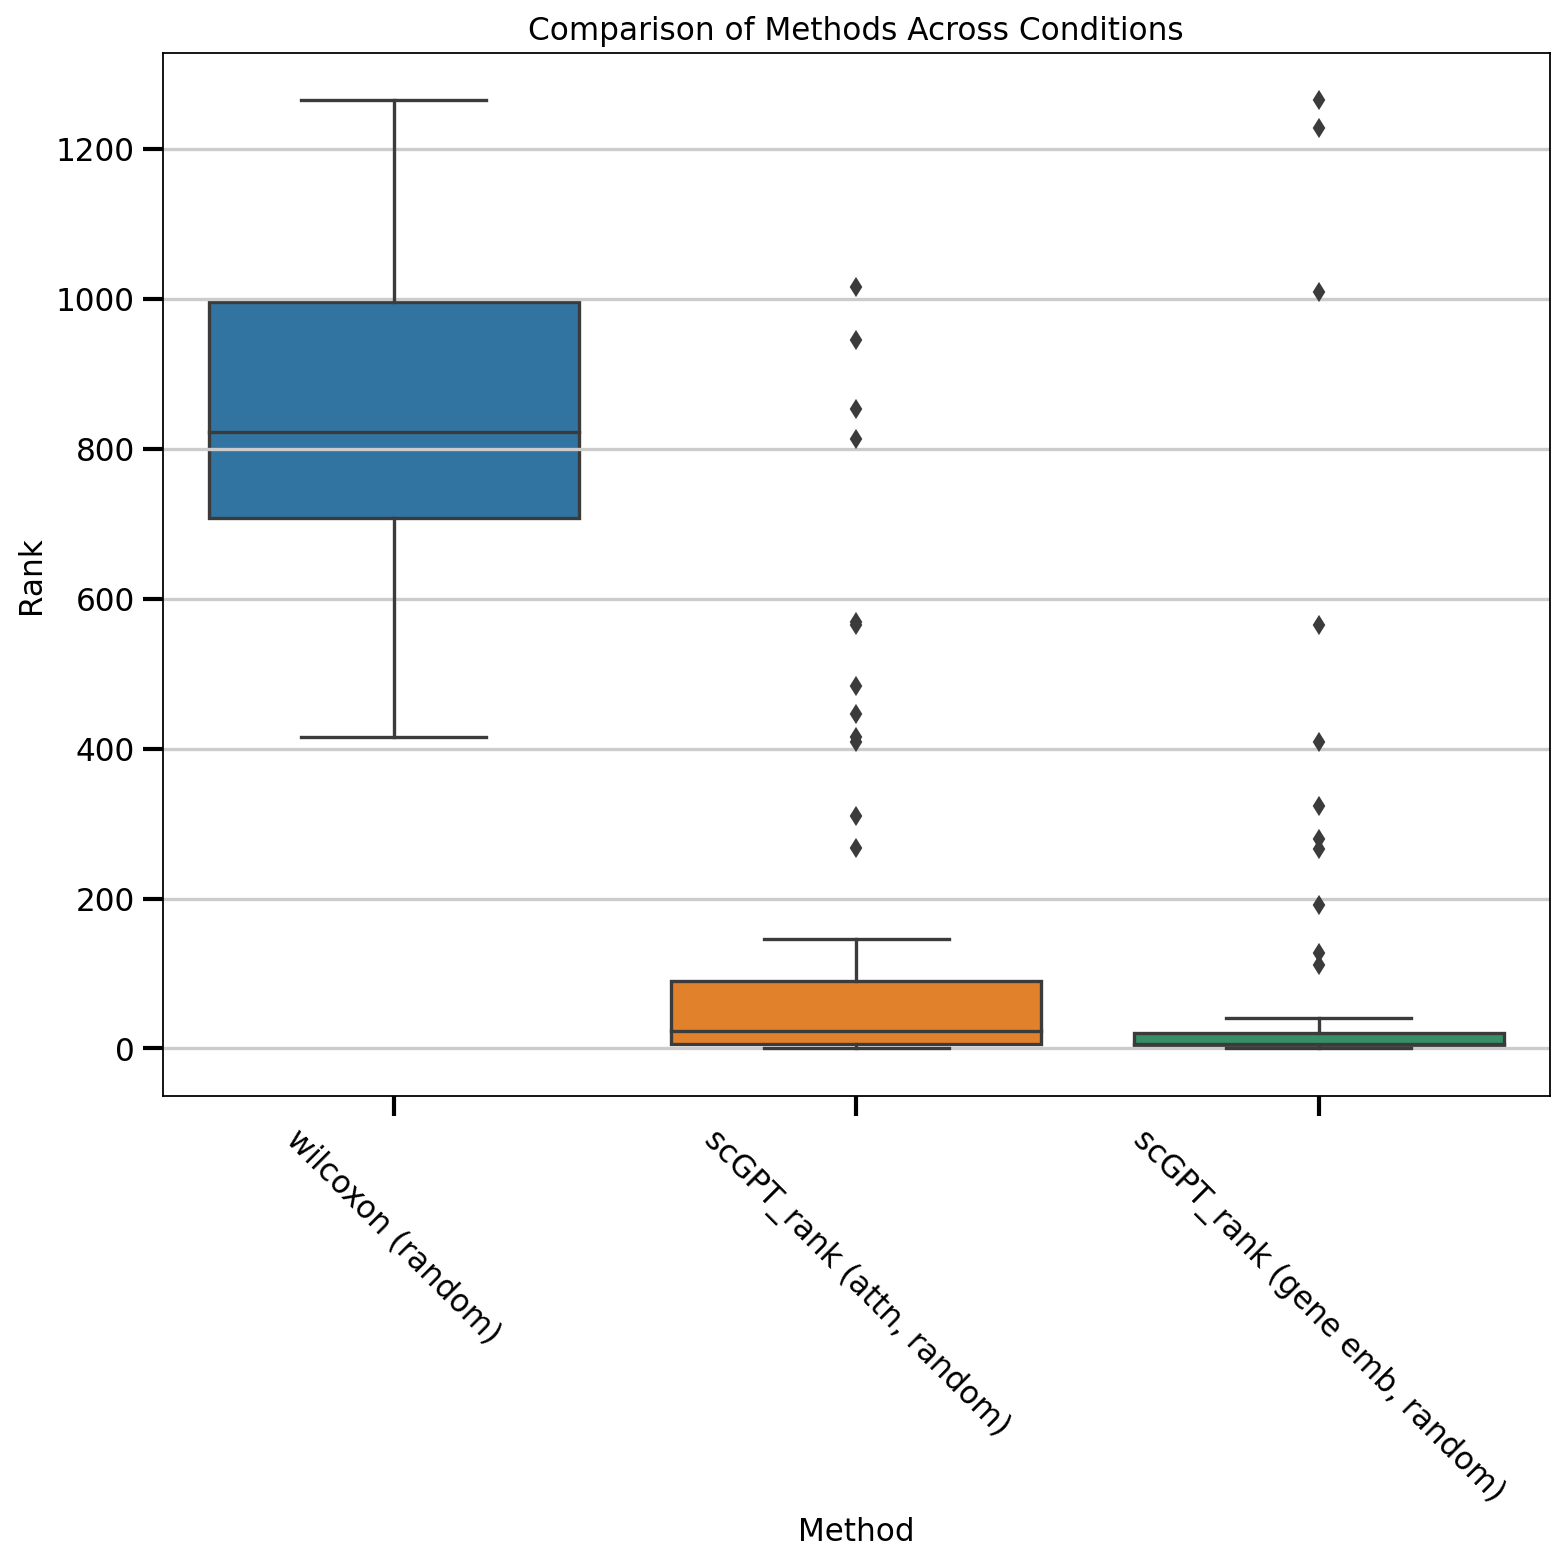

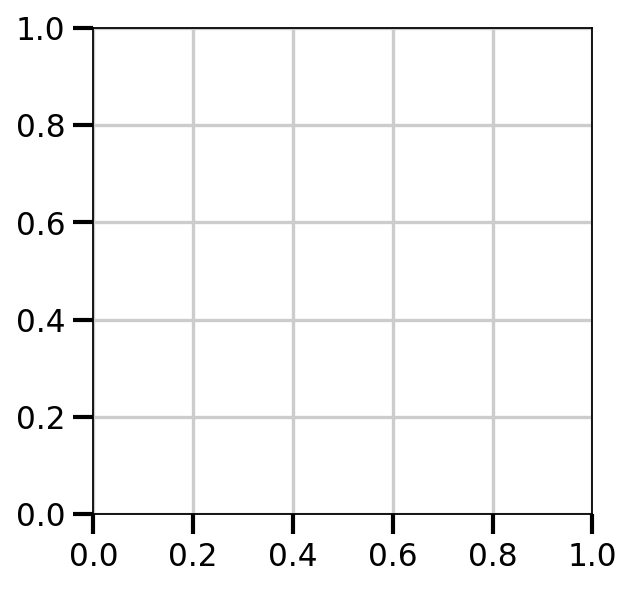

In [81]:
import seaborn as sns

df_melted = pd.melt(df_results_old, id_vars=['conditions'], 
                    value_vars=['wilcoxon (random)', 'scGPT_rank (attn, random)', 'scGPT_rank (gene emb, random)'], 
                    var_name='method', 
                    value_name='rank')

# Step 2: Create the box plot
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_melted, x='method', y='rank')

# Add titles and labels
plt.title('Comparison of Methods Across Conditions')
plt.xlabel('Method')
plt.ylabel('Rank')
plt.xticks(rotation=-45)

# Display the plot
plt.tight_layout()
plt.show()

plt.legend([],[], frameon=False)

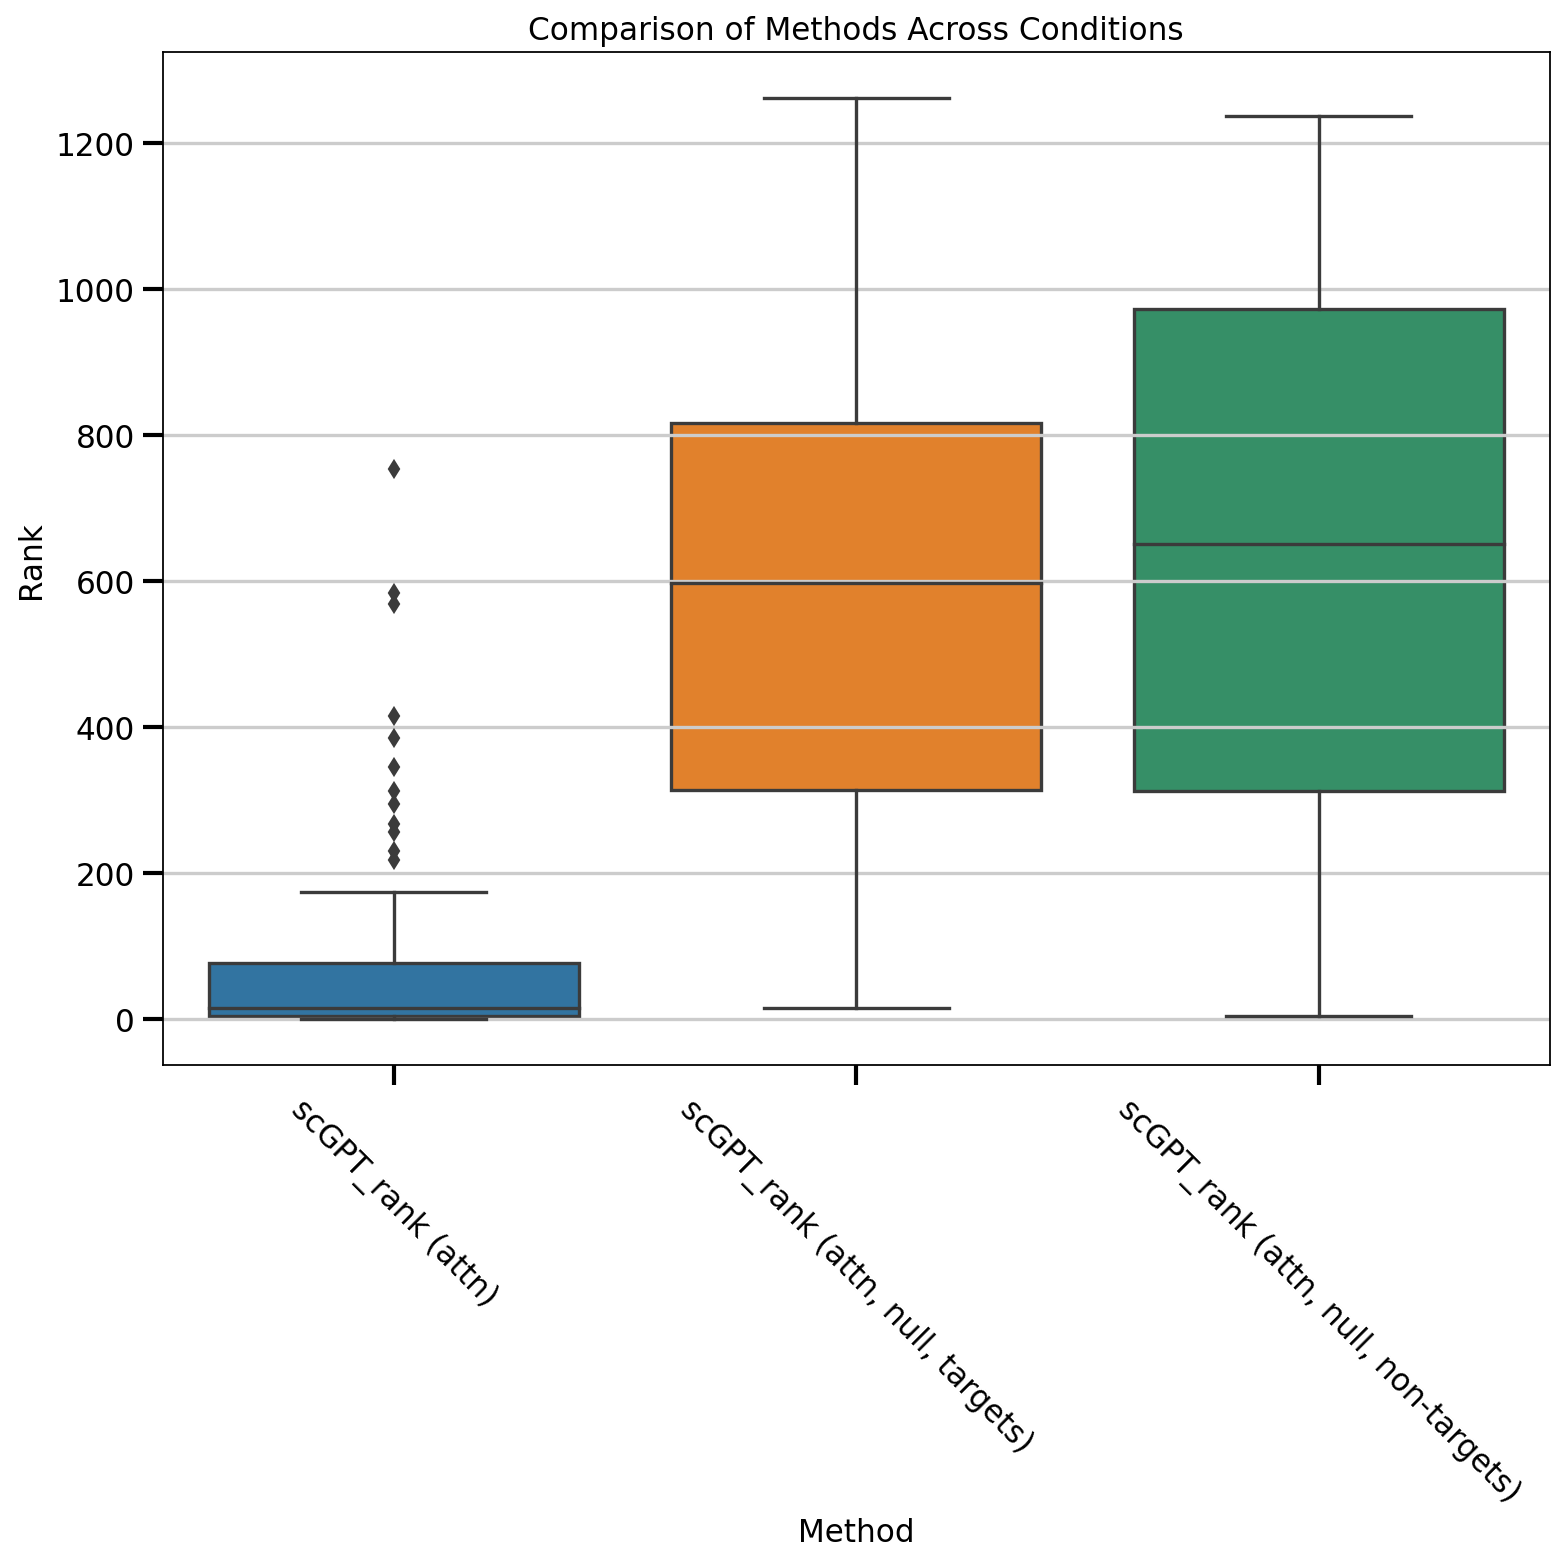

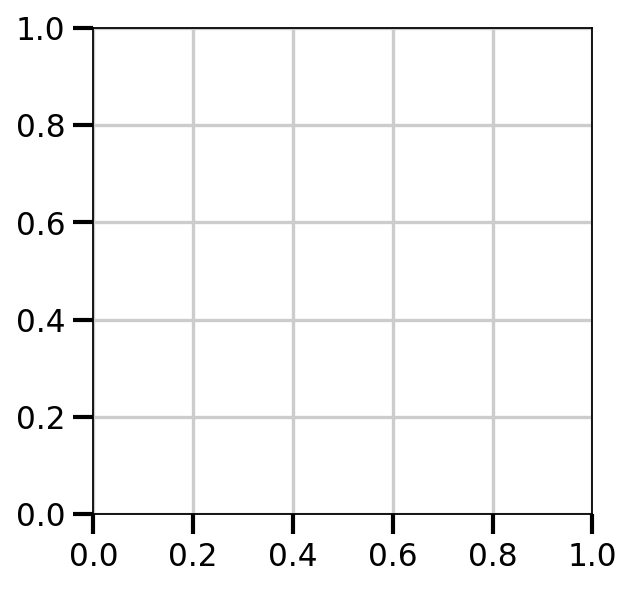

In [83]:
import seaborn as sns

df_melted = pd.melt(df_results_old, id_vars=['conditions'], 
                    value_vars=['scGPT_rank (attn)', 'scGPT_rank (attn, null, targets)', 'scGPT_rank (attn, null, non-targets)'], 
                    var_name='method', 
                    value_name='rank')

# Step 2: Create the box plot
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_melted, x='method', y='rank')

# Add titles and labels
plt.title('Comparison of Methods Across Conditions')
plt.xlabel('Method')
plt.ylabel('Rank')
plt.xticks(rotation=-45)

# Display the plot
plt.tight_layout()
plt.show()

plt.legend([],[], frameon=False)

In [66]:
df_results_old = df_results.copy()

In [76]:
import pandas as pd
import scipy.stats as stats

# Step 1: Extract the 'wilcoxon' and 'scGPT_rank (attn)' scores
opt_1 = 'scGPT_rank (gene emb)'
opt_2 = 'scGPT_rank (gene emb, null, non-targets)'
ranks_1 = df_results_old[opt_1]
ranks_2 = df_results_old[opt_2]

# Step 2: Perform paired t-test
t_stat, p_value = stats.ttest_rel(ranks_1, ranks_2, alternative='less')

# Step 3: Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Step 4: Determine if 'scGPT_rank (attn)' has larger ranks than 'wilcoxon'
if t_stat < 0 and p_value < 0.05:
    print("{} has significantly larger ranks than {}.".format(opt_2, opt_1))
else:
    print("No significant difference found, or {} has larger ranks.".format(opt_1))

T-statistic: -9.575832796777668
P-value: 6.851440943013974e-15
scGPT_rank (gene emb, null, non-targets) has significantly larger ranks than scGPT_rank (gene emb).


In [57]:
df_results_old

,conditions,wilcoxon,scGPT_rank (attn),scGPT_rank (gene emb),"scGPT_rank (attn, mean)","scGPT_rank (gene emb, mean)"
0,AMIGO3+ctrl,1098,569,409,569,409
1,ARHGAP22+ctrl,318,175,126,0,0
2,ASCC3+ctrl,36,15,48,0,0
3,BHLHE40+ctrl,3,584,558,0,0
4,CAD+ctrl,93,257,557,0,0
...,...,...,...,...,...,...
70,UFL1+ctrl,19,3,39,0,0
71,UFM1+ctrl,0,4,2,0,0
72,XRN1+ctrl,216,163,206,0,0
73,YIPF5+ctrl,11,16,55,0,0


In [58]:
df_results_old.mean()

wilcoxon                        69.920000
scGPT_rank (attn)               83.160000
scGPT_rank (gene emb)          110.320000
scGPT_rank (attn, mean)         70.506667
scGPT_rank (gene emb, mean)     68.320000
dtype: float64